# README
## 基本
- ロジスティック回帰
- 標準化 & GridSearch
- Embarked: 最頻値埋め & LabelEncoding
- Pclass: LabelEncoding
- FamilySize
- IsMaster

## ポイント
- 男性でも赤ちゃんは生存しやすい仮説 → 男の赤ちゃん(敬称がMaster)は助かる

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

%matplotlib inline

# データの準備

In [2]:
train_org = pd.read_csv('input/titanic/train.csv')
test_org = pd.read_csv('input/titanic/test.csv')

train = train_org[[
    # 'PassengerId',
    'Survived',
    'Pclass',
    'Name',
    'Sex',
    # 'Age',
    'SibSp',
    'Parch',
    # 'Ticket',
    # 'Fare',
    # 'Cabin',
    'Embarked'
]].copy()

test = test_org[[
    # 'PassengerId',
    'Pclass',
    'Name',
    'Sex',
    # 'Age',
    'SibSp',
    'Parch',
    # 'Ticket',
    # 'Fare',
    # 'Cabin',
    'Embarked'
]].copy()

# 幼い乗客の生存率を調べてみる

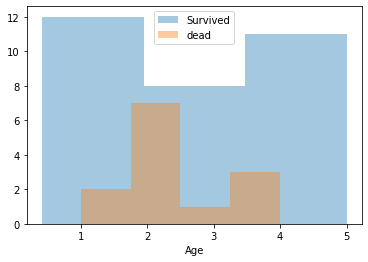

In [9]:
age_survived = train_org[train_org['Survived'] == 1]['Age'].dropna()
age_dead = train_org[train_org['Survived'] == 0]['Age'].dropna()

sns.distplot(age_survived[age_survived <= 5], kde=False, label='Survived')
sns.distplot(age_dead[age_dead <= 5], kde=False, label='dead')

plt.legend()

# 前処理

In [4]:
# データが小さいことに加え、すぐに試せることを重視して、すべての前処理を1つの関数にしている
def preprocess(train_org, test_org):
    train = train_org.copy()
    test = test_org.copy()

    # Sex
    sex_dict = {'male': 0, 'female': 1}
    train['Sex'] = train['Sex'].map(sex_dict)
    test['Sex'] = test['Sex'].map(sex_dict)

    # Embarked
    train['Embarked'] = train['Embarked'].fillna('S')
    embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
    train['Embarked'] = train['Embarked'].map(embarked_dict)
    test['Embarked'] = test['Embarked'].map(embarked_dict)

    # Family
    train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
    train.drop(columns=['SibSp', 'Parch'], inplace=True)
    test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
    test.drop(columns=['SibSp', 'Parch'], inplace=True)

    # IsMaster
    # `Master` は 幼い子(男児のみ？) につけられる敬称
    train['Title'] = train['Name'].str.extract(r',\s([a-zA-Z]+)\.')
    train['IsMaster'] = (train['Title'] == 'Master').astype(int)
    train.drop(columns=['Name', 'Title'], inplace=True)
    test['Title'] = test['Name'].str.extract(r',\s([a-zA-Z]+)\.')
    test['IsMaster'] = (test['Title'] == 'Master').astype(int)
    test.drop(columns=['Name', 'Title'], inplace=True)

    return train.drop(columns=['Survived']), train[['Survived']], test


X_train, y_train, X_test = preprocess(train, test)

X_train.head()

,Pclass,Sex,Embarked,FamilySize,IsMaster
0,3,0,0,2,0
1,1,1,1,2,0
2,3,1,0,1,0
3,1,1,0,2,0
4,3,0,0,1,0


# Bulding model

In [5]:
def show_coefs_from_grid(grid, train):
    best_logreg = grid.best_estimator_.named_steps['logreg']

    for col_name, coef in zip(train.columns, best_logreg.coef_[0]):
        print(f'{coef:.4f}{col_name} + ', end='')

    intercept = best_logreg.intercept_[0]
    print(f'{intercept:.4f}')

In [6]:
skf = StratifiedKFold(n_splits=10, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression())])

param_grid = {'logreg__C': [10**x for x in range(-3, 3)]}

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=skf,
                    n_jobs=-1)

grid = grid.fit(X_train, y_train)

print(grid.best_params_, grid.best_score_)

print('Model: ', end='')
show_coefs_from_grid(grid, X_train)

{'logreg__C': 0.1} 0.8327721661054994
Model: -0.7837Pclass + 1.3874Sex + 0.1348Embarked + -0.4483FamilySize + 0.6381IsMaster + -0.6060


In [7]:
y_pred = grid.predict(X_test)

y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Submission

In [8]:
submit_data = pd.read_csv('input/titanic/gender_submission.csv')
submit_data['Survived'] = y_pred
submit_data.to_csv('submission/hoge.csv', index=False)

おわり